## **EXP3 Predicting Real Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file includes EXP3 analysis and results. Files used were created in preprocessing/EXP3_pseudos notebook, and deconvolution was performed with CIBERSORTx through Docker in Run_cibersort.py*

**Summary:**
Using single nucleus and single cell RNA-seq datasets with real missing cell types.

The residual is calculated in three different ways named: Residual (comparing CIBERSORTx calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from CIBERSORTx reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
CIBERSORTx

**Factorization Methods:**
NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess as prep
from functions import validation_processing as vp
from importlib import reload
reload(prep)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = "/../data/"
aug_data_path = "/../data/EXP3/"
path_results = "/../results/EXP3/"
data_path = "/../data/EXP3/cibersort/"
cibersort_path = "/../data/EXP3/cibersort_results/"
bulkprop_type = "realistic"
noise_type = "nonoise"
num_missing_cells = [0,2]
nmf_cut = "minimum_value"
num_samples = 10000

In [3]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
cibersort_path = f"{actual_path}{cibersort_path}"
path_results = f"{actual_path}{path_results}"
bulk_type = f"{bulkprop_type}prop_{noise_type}"

Opening mixture file of pseudobulks and anndata for reference:

In [4]:
pseudo_path = os.path.join(data_path, f"{res_name}_{bulk_type}_mixture.txt")
pseudo_path = Path(pseudo_path)
# Open the file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep="\t")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,54.0,129.0,16.0,2119.0,122.0,37.0,696.0,15.0,156.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
1,56.0,128.0,16.0,2985.0,139.0,56.0,679.0,15.0,249.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,56.0,115.0,13.0,2966.0,94.0,53.0,747.0,12.0,260.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44.0,100.0,18.0,3364.0,114.0,66.0,806.0,16.0,222.0,9.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0
4,59.0,127.0,13.0,2712.0,93.0,46.0,699.0,10.0,220.0,11.0,...,0.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57.0,120.0,16.0,2365.0,85.0,54.0,720.0,12.0,259.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
996,69.0,128.0,21.0,2261.0,66.0,54.0,748.0,19.0,216.0,5.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0
997,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0
998,42.0,112.0,9.0,2961.0,118.0,65.0,702.0,15.0,209.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [5]:
#and importing anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata_copy = sc_adata.copy()
sc_adata

AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
#and importing anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [7]:
#making sure cell types are capitalized:
sn_adata.obs["cell_types"] = vp.capitalize_first_letters(sn_adata.obs["cell_types"])
sc_adata.obs["cell_types"] = vp.capitalize_first_letters(sc_adata.obs["cell_types"])

print(Counter(sc_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sc_adata.obs.cell_types.unique())
cell_order = sc_adata.obs.cell_types.unique()

Counter({'Preadipocyte': 13461, 'Macrophage': 1410, 'Dendritic cell': 983, 'T cell': 807, 'Monocyte': 636, 'Endothelial cell': 542, 'Immature nk t cell': 389, 'Endothelial cell of lymphatic vessel': 157, 'Mast cell': 53, 'Pericyte cell': 52})


Making Cell Type References:

Single-Nucleus:

In [8]:
# Making cell type reference without snaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw.index = gene_ids.values
ref_raw

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
A1BG,206.0,13.0,103.0,56.0,18.0,88.0,222.0,121.0,218.0,152.0,102.0,100.0
A1BG-AS1,516.0,30.0,420.0,153.0,29.0,245.0,430.0,269.0,678.0,367.0,371.0,236.0
A1CF,12.0,109.0,6.0,4.0,8.0,32.0,10.0,15.0,32.0,0.0,0.0,0.0
A2M,1710.0,2636.0,10507.0,2173.0,22201.0,4123.0,11042.0,11994.0,8116.0,17191.0,2044.0,7925.0
A2M-AS1,76.0,295.0,121.0,97.0,261.0,144.0,80.0,1480.0,135.0,2470.0,60.0,1205.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HIST1H3G,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,31.0,0.0,8.0,0.0
PAEP,4.0,3.0,4.0,6.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#clipping before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df.index = gene_ids.index
ref_df_sn = ref_df.copy()
ref_raw_sn = ref_raw.copy()
ref_df_sn

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
A1BG,0.046188,0.002915,0.023094,0.012556,0.004036,0.019731,0.049776,0.027130,0.048879,0.034081,0.022870,0.022422
A1BG-AS1,0.115695,0.006726,0.094170,0.034305,0.006502,0.054933,0.096413,0.060314,0.152018,0.082287,0.083184,0.052915
A1CF,0.002691,0.024439,0.001345,0.000897,0.001794,0.007175,0.002242,0.003363,0.007175,0.000000,0.000000,0.000000
A2M,0.383408,0.591031,1.000000,0.487220,1.000000,0.924439,1.000000,1.000000,1.000000,1.000000,0.458296,1.000000
A2M-AS1,0.017040,0.066143,0.027130,0.021749,0.058520,0.032287,0.017937,0.331839,0.030269,0.553812,0.013453,0.270179
...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.000448,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL109945.1,0.000000,0.000673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HIST1H3G,0.000224,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.006951,0.000000,0.001794,0.000000
PAEP,0.000897,0.000673,0.000897,0.001345,0.000673,0.000000,0.001345,0.000000,0.000000,0.000000,0.000000,0.000000


Since we created the pseudobulks with single-nucleus, we're using single nucleus to create the reference:

In [10]:
ref_raw = ref_raw_sn.copy()
ref_df = ref_df_sn.copy()
ref_df

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
A1BG,0.046188,0.002915,0.023094,0.012556,0.004036,0.019731,0.049776,0.027130,0.048879,0.034081,0.022870,0.022422
A1BG-AS1,0.115695,0.006726,0.094170,0.034305,0.006502,0.054933,0.096413,0.060314,0.152018,0.082287,0.083184,0.052915
A1CF,0.002691,0.024439,0.001345,0.000897,0.001794,0.007175,0.002242,0.003363,0.007175,0.000000,0.000000,0.000000
A2M,0.383408,0.591031,1.000000,0.487220,1.000000,0.924439,1.000000,1.000000,1.000000,1.000000,0.458296,1.000000
A2M-AS1,0.017040,0.066143,0.027130,0.021749,0.058520,0.032287,0.017937,0.331839,0.030269,0.553812,0.013453,0.270179
...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.000448,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL109945.1,0.000000,0.000673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HIST1H3G,0.000224,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.006951,0.000000,0.001794,0.000000
PAEP,0.000897,0.000673,0.000897,0.001345,0.000673,0.000000,0.001345,0.000000,0.000000,0.000000,0.000000,0.000000


## **Reading In and QCing the CIBERSORTx Results:**

CIBERSORTx Results:

In [11]:
#import all CIBERSORTx results and real proportions
cibersort_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_cibersort = dict()
for num in num_missing_cells:
    #import cibersort proportions
    cibersort_results_path = os.path.join(cibersort_path, f"{bulk_type}_{num}missing/CIBERSORTx_Results.txt")
    cibersort_results_path = Path(cibersort_results_path)
    # Open the CSV file in read mode
    cibersort_prop[num] = pd.read_csv(cibersort_results_path, sep="\t")
    cibersort_prop[num] = cibersort_prop[num].drop(labels = ["Mixture", "P-value", "Correlation", "RMSE"], axis = 1)
    cibersort_prop[num].columns  = vp.capitalize_first_letters(cibersort_prop[num].columns)
    #realp proportions
    realrebprop_results_path = os.path.join(data_path, f"{res_name}_{bulk_type}_prop.txt")
    realrebprop_results_path = Path(realrebprop_results_path)
    # Open the CSV file in read mode
    real_prop_reb[num] = pd.read_csv(realrebprop_results_path, sep="\t", index_col=0)
    real_prop_reb[num].index = range(0,len(real_prop_reb[num]))
    real_prop_reb[num].columns = vp.capitalize_first_letters( real_prop_reb[num].columns)
    #and the reference used in cibersort
    ref_results_path = os.path.join(cibersort_path, f"{bulk_type}_{num}missing/CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_cibersort[num] = pd.read_csv(ref_results_path, sep="\t")
    ref_cibersort[num] = ref_cibersort[num].rename(columns = {'NAME':'gene_ids'})
    ref_cibersort[num].index = ref_cibersort[num]["gene_ids"]
    gene_ids[num] = ref_cibersort[num].index
    ref_cibersort[num] = ref_cibersort[num].drop(labels= "gene_ids", axis = 1)
    ref_cibersort[num].columns = vp.capitalize_first_letters(ref_cibersort[num].columns)
cibersort_prop[0]

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_22205/2527591167.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_ids[num] = ref_cibersort[num].index


,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
0,0.214936,0.435582,0.093723,0.145192,0.009615,0.022007,0.013867,0.006773,0.029909,0.013144,0.014342,0.000911
1,0.191523,0.346443,0.080778,0.188230,0.085350,0.023030,0.018268,0.006601,0.020222,0.027737,0.011316,0.000502
2,0.231652,0.329350,0.053092,0.194506,0.119788,0.011427,0.015999,0.011998,0.017734,0.004483,0.007193,0.002777
3,0.094051,0.420752,0.127028,0.170347,0.087761,0.011347,0.023788,0.003734,0.043194,0.009555,0.008441,0.000000
4,0.203715,0.323477,0.159417,0.173991,0.044306,0.009837,0.024183,0.007891,0.047375,0.003193,0.002615,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.204293,0.348485,0.090689,0.177595,0.038555,0.070195,0.017427,0.017893,0.031688,0.001948,0.001232,0.000000
996,0.202588,0.409569,0.070427,0.186345,0.029633,0.018099,0.043380,0.012760,0.016382,0.002933,0.007885,0.000000
997,0.213010,0.417615,0.084424,0.132698,0.054742,0.016253,0.020933,0.025381,0.030903,0.002343,0.001699,0.000000
998,0.147600,0.422377,0.120449,0.159596,0.059902,0.016641,0.016113,0.014411,0.033778,0.003980,0.005153,0.000000


In [12]:
real_prop_reb[0]

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
0,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.020180,0.015646
1,0.230380,0.177024,0.096562,0.279433,0.110179,0.020464,0.007850,0.004998,0.004378,0.058810,0.003665,0.006257
2,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.002560,0.022390,0.006150,0.004275,0.000941,0.006951
3,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.011980,0.004328
4,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.252649,0.175555,0.108480,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
996,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.000550
997,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.020500,0.049767,0.001209,0.001988,0.007365,0.001881
998,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.000920,0.008269,0.004246,0.008121


In [13]:
#rebalancing proportions with the missing cell types, and deleting from [2]
real_prop_reb[2] = real_prop_reb[2].drop(['Mesothelial cell','Fat cell'], axis=1) 
real_prop_reb[2] = real_prop_reb[2].div(real_prop_reb[2].sum(axis=1), axis=0)
real_prop_reb[2]

,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
0,0.243892,0.492832,0.037436,0.042634,0.008143,0.030572,0.003782,0.066987,0.041527,0.032196
1,0.162947,0.471540,0.185926,0.034532,0.013246,0.008435,0.007388,0.099242,0.006185,0.010558
2,0.114435,0.509977,0.286340,0.009191,0.004737,0.041428,0.011379,0.007910,0.001741,0.012862
3,0.271060,0.423295,0.189083,0.009622,0.025585,0.010012,0.013851,0.030868,0.019559,0.007066
4,0.349037,0.458659,0.104464,0.007395,0.024062,0.033428,0.004099,0.011356,0.002015,0.005485
...,...,...,...,...,...,...,...,...,...,...
995,0.189719,0.482119,0.100658,0.136136,0.010396,0.061093,0.007186,0.002220,0.002917,0.007557
996,0.162119,0.552184,0.082451,0.030445,0.100367,0.049432,0.015111,0.002267,0.004562,0.001061
997,0.217707,0.428189,0.165778,0.019224,0.041912,0.101749,0.002472,0.004065,0.015058,0.003845
998,0.275079,0.458155,0.162132,0.018567,0.003357,0.044815,0.001617,0.014536,0.007464,0.014277


In [14]:
#matching genes in reference, pseudobulks in gene_ids[num]
sc_adata_copy = sc_adata.copy()
sc_adata = dict()

pseudo_df_copy = pseudo_df.copy()
pseudo_df = dict()

ref_raw_copy = ref_raw.copy()
ref_raw = dict()

ref_df_copy = ref_df.copy()
ref_df = dict()

gene_ids = dict()

ref_raw_copy.index = ref_df_copy.index


#cutting to gene_ids in reference
for num in num_missing_cells:
    intersect_genes = np.intersect1d(ref_cibersort[num].index, pseudo_df_copy.columns)
    pseudo_df[num] = pseudo_df_copy[intersect_genes]
    gene_ids[num] = intersect_genes
    sc_adata[num] = sc_adata_copy[:, sc_adata_copy.var_names.isin(intersect_genes)]
    ref_df[num] = ref_df_copy.loc[intersect_genes]
    ref_raw[num] = ref_raw_copy.loc[intersect_genes]

In [15]:
#and deleting the cell types from the reference
ref_df[2] = ref_df[2].drop(['Mesothelial cell','Fat cell'], axis=1) 
ref_raw[2] = ref_raw[2].drop(['Mesothelial cell','Fat cell'], axis=1) 

In [16]:
#matching cell types in reference to proportions from CIBERSORTx
for num in num_missing_cells:
    ref_df[num] = ref_df[num][cibersort_prop[num].columns]
    ref_raw[num] = ref_raw[num][cibersort_prop[num].columns]

QC imported files:

In [17]:
ref_cibersort[0]

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
gene_ids,,,,,,,,,,,,
A2M.AS1,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,206.545291,1.000000,1.00000
A2ML1.AS1,1.000000,127.286221,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.00000
AADACL2.AS1,1.000000,1.000000,106.580934,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.00000
AATF,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,188.490167,107.565737,1.000000,142.252460,153.63756
ABAT,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,110.822154,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,193.227640,115.190535,1.000000,152.309162,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.00000
ZRANB2.AS2,1.000000,95.656601,1.000000,435.965594,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.00000
ZSCAN31,126.252606,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.00000


In [18]:
cibersort_prop[2]

,Dendritic cell,Monocyte,Preadipocyte,Endothelial cell of lymphatic vessel,Macrophage,T cell,Endothelial cell,Immature nk t cell,Pericyte cell,Mast cell
0,0.058952,0.025845,0.659739,0.004559,0.027174,0.017928,0.090533,0.0,0.115269,0.000000
1,0.013414,0.021642,0.626753,0.000000,0.014617,0.003121,0.193489,0.0,0.125449,0.001514
2,0.004263,0.015858,0.583319,0.000000,0.002109,0.016359,0.272531,0.0,0.105561,0.000000
3,0.041692,0.062590,0.558809,0.000000,0.008966,0.000000,0.214949,0.0,0.112993,0.000000
4,0.047266,0.029311,0.653585,0.000000,0.033254,0.015376,0.148598,0.0,0.072610,0.000000
...,...,...,...,...,...,...,...,...,...,...
995,0.005769,0.027374,0.654862,0.034075,0.017389,0.029906,0.147154,0.0,0.083471,0.000000
996,0.024568,0.022185,0.678083,0.013782,0.006470,0.017088,0.084167,0.0,0.153658,0.000000
997,0.027122,0.038771,0.562131,0.000000,0.003293,0.041740,0.195560,0.0,0.131383,0.000000
998,0.044352,0.022803,0.596487,0.000000,0.026537,0.025646,0.184789,0.0,0.099386,0.000000


In [19]:
pseudo_df[0]

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
0,1103.0,646.0,8422.0,7109.0,7435.0,519.0,860.0,506.0,607.0,1730.0,...,653.0,544.0,1670.0,157.0,1130.0,971.0,1866.0,606.0,979.0,943.0
1,998.0,500.0,9547.0,6860.0,7976.0,695.0,739.0,401.0,905.0,1509.0,...,542.0,467.0,1469.0,100.0,1101.0,1044.0,1670.0,541.0,876.0,941.0
2,1031.0,513.0,9806.0,7187.0,7501.0,937.0,728.0,352.0,884.0,1380.0,...,315.0,472.0,1473.0,108.0,1090.0,1097.0,1736.0,743.0,1048.0,903.0
3,1152.0,597.0,9598.0,6662.0,8552.0,635.0,840.0,677.0,977.0,2019.0,...,763.0,541.0,1548.0,75.0,1205.0,1186.0,1709.0,476.0,937.0,996.0
4,1040.0,624.0,9097.0,6929.0,8342.0,605.0,743.0,511.0,743.0,2184.0,...,735.0,508.0,1456.0,88.0,1308.0,990.0,1655.0,703.0,838.0,946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1052.0,566.0,9920.0,7321.0,8471.0,629.0,792.0,467.0,688.0,1629.0,...,494.0,546.0,1548.0,336.0,1210.0,1061.0,1853.0,590.0,1104.0,955.0
996,1121.0,525.0,10348.0,8049.0,8399.0,475.0,809.0,417.0,651.0,1551.0,...,317.0,549.0,1761.0,161.0,1211.0,963.0,1852.0,628.0,1016.0,942.0
997,1084.0,587.0,8547.0,6709.0,6755.0,583.0,804.0,442.0,762.0,1670.0,...,518.0,514.0,1545.0,191.0,1158.0,971.0,1886.0,717.0,960.0,933.0
998,1133.0,567.0,9863.0,7014.0,8624.0,596.0,759.0,573.0,778.0,1883.0,...,606.0,537.0,1553.0,164.0,1167.0,988.0,1671.0,590.0,866.0,976.0


In [20]:
###QC dimensions
num = 0
print(gene_ids[num].shape)
print(ref_df[num].shape)
print(pseudo_df[num].shape)
print(ref_cibersort[num].shape)

(2777,)
(2777, 12)
(1000, 2777)
(2886, 12)


In [21]:
###QC dimensions
num = 2
print(gene_ids[num].shape)
print(ref_df[num].shape)
print(pseudo_df[num].shape)
print(ref_cibersort[num].shape)

(2423,)
(2423, 10)
(1000, 2423)
(2460, 10)


Ordering order of cells:

In [22]:
for num in num_missing_cells:
    real_prop_reb[num] = prep.sort_columns_alphabetically(real_prop_reb[num])
    cibersort_prop[num] = prep.sort_columns_alphabetically(cibersort_prop[num])
    ref_df[num] = prep.sort_columns_alphabetically(ref_df[num])
    ref_cibersort[num] = prep.sort_columns_alphabetically(ref_cibersort[num])

Visualize CIBERSORTx proportions:

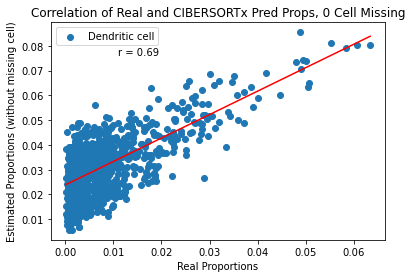

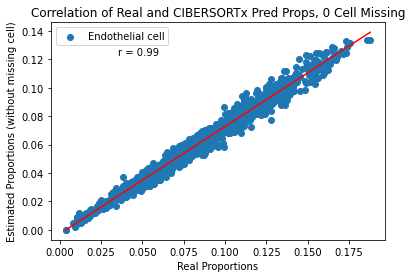

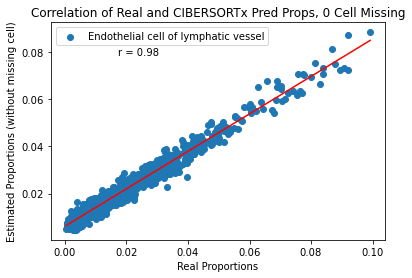

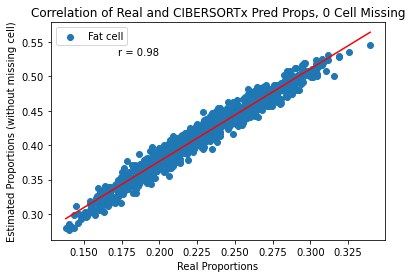

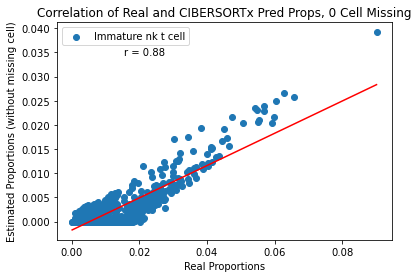

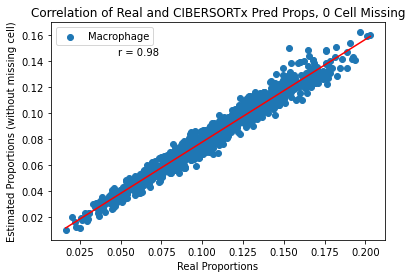

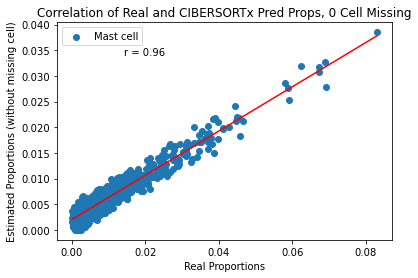

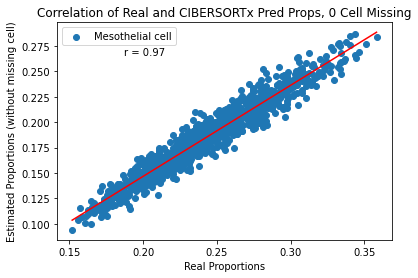

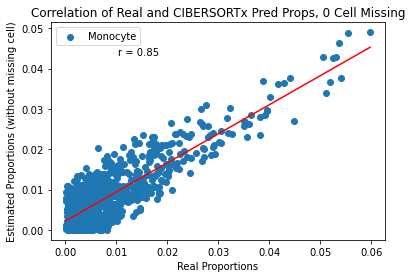

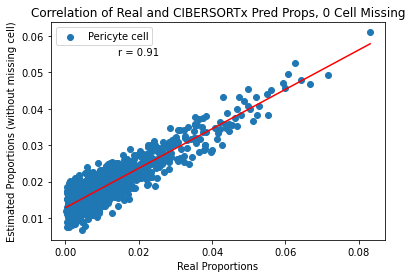

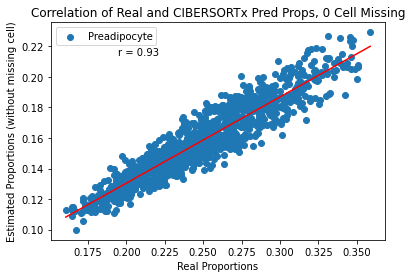

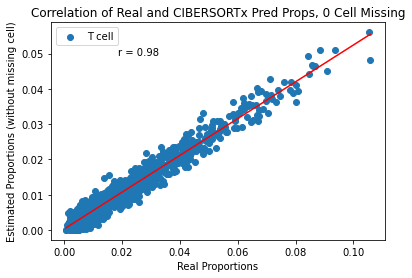

In [23]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0
for col_cell in real_prop_reb[num].columns:
    x = real_prop_reb[num][col_cell].values.astype(float)
    y = cibersort_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    # if we're using realistic proportions, RMSE is meaningless.
    if 'random' in bulkprop_type:
        # Calculate RMSE
        rmse = np.sqrt(((x - y) ** 2).mean())
        # And annotate
        plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.2, 0.85), xycoords='axes fraction')   
    else:     
        plt.annotate(f'r = {r:.2f}', xy=(0.2, 0.85), xycoords='axes fraction')   
    plt.xlabel('Real Proportions')

    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and CIBERSORTx Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

In [24]:
num_missing_cells = [0,2]

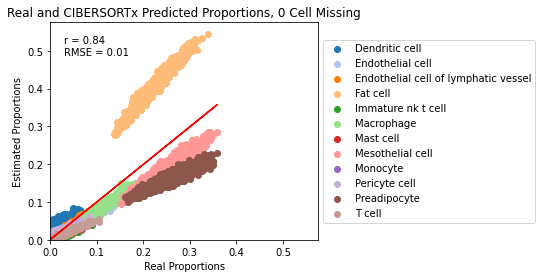

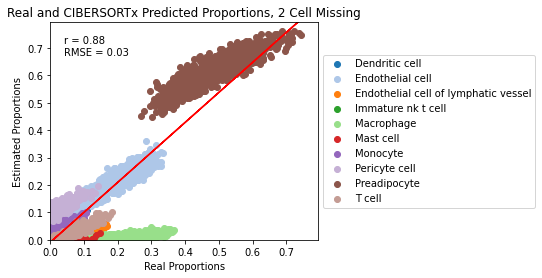

In [25]:
#Comparnig performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
# Create a dictionary to store color mapping for each cell type
cell_type_colors = {}
for num in num_missing_cells:

    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = cibersort_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]

    # Scatter plot with colored points for each cell type
    fig, ax = plt.subplots()

    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]

        # Check if the cell type already has a color assigned
        if cell_type not in cell_type_colors:
            # Assign a unique color for each cell type
            color = cmap(len(cell_type_colors))
            cell_type_colors[cell_type] = color
        else:
            color = cell_type_colors[cell_type]

        ax.scatter(x, y, label=cell_type, color=color)

    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")

    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())

    # Calculate RMSE
    rmse = np.sqrt(((x - y) ** 2).mean())

    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')   
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions')
    plt.title(f'Real and CIBERSORTx Predicted Proportions, {num} Cell Missing')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    max_val = max([real_proportions.max(), estimated_proportions.max()])
    if bulkprop_type == "realistic":
        ax.set_xlim(0,max_val+.03)
        ax.set_ylim(0,max_val+.03)
    else:    
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    plt.show()

And saving results:

In [26]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float)
    estimated_proportions = cibersort_prop[num].values.astype(float)
    cell_types = real_prop_reb[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])

# Save dataframes to .txt files
real_filename = f"{path_results}EXP3_cibersortx_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename = f"{path_results}EXP3_cibersortx_adp_{bulkprop_type}_{noise_type}_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

## **Extracting Missing Cell Information:**

In [27]:
cells_to_miss = dict()
missing_cell_prop  = dict()
#only 2 missing cells
num = 2
#cells that are missing
cells_missing = np.setdiff1d(real_prop_reb[0].columns, cibersort_prop[2].columns)
#extracting real proportions from missing cells
missing_cell_prop[num] = real_prop_reb[0][cells_missing]
print(f"{num} missing: {missing_cell_prop[num].shape}")

2 missing: (1000, 2)


In [28]:
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_df[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.95)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])

## **Calculate Residuals:**

Residual uses:

Pseudobulks - [Calculated_Proportions * Reference]

QC:

In [29]:
print(pseudo_df[2].max().max())
print(pseudo_scaled[2].max().max())

42641.0
1.0000000000000009


In [30]:
pseudo_df[0]

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
0,1103.0,646.0,8422.0,7109.0,7435.0,519.0,860.0,506.0,607.0,1730.0,...,653.0,544.0,1670.0,157.0,1130.0,971.0,1866.0,606.0,979.0,943.0
1,998.0,500.0,9547.0,6860.0,7976.0,695.0,739.0,401.0,905.0,1509.0,...,542.0,467.0,1469.0,100.0,1101.0,1044.0,1670.0,541.0,876.0,941.0
2,1031.0,513.0,9806.0,7187.0,7501.0,937.0,728.0,352.0,884.0,1380.0,...,315.0,472.0,1473.0,108.0,1090.0,1097.0,1736.0,743.0,1048.0,903.0
3,1152.0,597.0,9598.0,6662.0,8552.0,635.0,840.0,677.0,977.0,2019.0,...,763.0,541.0,1548.0,75.0,1205.0,1186.0,1709.0,476.0,937.0,996.0
4,1040.0,624.0,9097.0,6929.0,8342.0,605.0,743.0,511.0,743.0,2184.0,...,735.0,508.0,1456.0,88.0,1308.0,990.0,1655.0,703.0,838.0,946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1052.0,566.0,9920.0,7321.0,8471.0,629.0,792.0,467.0,688.0,1629.0,...,494.0,546.0,1548.0,336.0,1210.0,1061.0,1853.0,590.0,1104.0,955.0
996,1121.0,525.0,10348.0,8049.0,8399.0,475.0,809.0,417.0,651.0,1551.0,...,317.0,549.0,1761.0,161.0,1211.0,963.0,1852.0,628.0,1016.0,942.0
997,1084.0,587.0,8547.0,6709.0,6755.0,583.0,804.0,442.0,762.0,1670.0,...,518.0,514.0,1545.0,191.0,1158.0,971.0,1886.0,717.0,960.0,933.0
998,1133.0,567.0,9863.0,7014.0,8624.0,596.0,759.0,573.0,778.0,1883.0,...,606.0,537.0,1553.0,164.0,1167.0,988.0,1671.0,590.0,866.0,976.0


In [31]:
cibersort_prop[0]

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Fat cell,Immature nk t cell,Macrophage,Mast cell,Mesothelial cell,Monocyte,Pericyte cell,Preadipocyte,T cell
0,0.029909,0.009615,0.022007,0.435582,0.000911,0.093723,0.013144,0.214936,0.014342,0.013867,0.145192,0.006773
1,0.020222,0.085350,0.023030,0.346443,0.000502,0.080778,0.027737,0.191523,0.011316,0.018268,0.188230,0.006601
2,0.017734,0.119788,0.011427,0.329350,0.002777,0.053092,0.004483,0.231652,0.007193,0.015999,0.194506,0.011998
3,0.043194,0.087761,0.011347,0.420752,0.000000,0.127028,0.009555,0.094051,0.008441,0.023788,0.170347,0.003734
4,0.047375,0.044306,0.009837,0.323477,0.000000,0.159417,0.003193,0.203715,0.002615,0.024183,0.173991,0.007891
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.031688,0.038555,0.070195,0.348485,0.000000,0.090689,0.001948,0.204293,0.001232,0.017427,0.177595,0.017893
996,0.016382,0.029633,0.018099,0.409569,0.000000,0.070427,0.002933,0.202588,0.007885,0.043380,0.186345,0.012760
997,0.030903,0.054742,0.016253,0.417615,0.000000,0.084424,0.002343,0.213010,0.001699,0.020933,0.132698,0.025381
998,0.033778,0.059902,0.016641,0.422377,0.000000,0.120449,0.003980,0.147600,0.005153,0.016113,0.159596,0.014411


In [32]:
#Residual with the non-scaled pseudobulk and calculated ref
residuals = dict()
for num in num_missing_cells:
    res = pseudo_df[num].values  - (ref_raw[num] @ cibersort_prop[num].T).T
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[0]  

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
0,-1353.720468,-684.067599,5067.920681,3155.74251,3926.966196,-325.299737,-1202.494184,-926.401908,-410.510807,-615.173943,...,-320.417223,-731.914242,-1210.707678,-37.351138,-1356.017355,-1314.501467,-1518.443114,-683.091772,-980.499871,-1328.664941
1,-1309.10797,-697.653977,6337.7232,3172.752609,4706.382752,-386.696047,-1127.429166,-799.267337,-435.867368,-734.630992,...,-286.483624,-702.29192,-1121.928004,-96.036095,-1231.530309,-1309.359096,-1407.681077,-723.413911,-1037.708125,-1144.129606
2,-1233.800165,-609.721729,6599.903271,3450.427368,4394.478725,-375.442199,-1108.93644,-716.373646,-478.701298,-785.485265,...,-348.677626,-685.09871,-1164.434144,-67.243985,-1205.195052,-1217.059206,-1463.257308,-660.892352,-938.853923,-1134.637797
3,-1309.418796,-751.940517,6300.807688,3019.045841,4846.460224,-294.125713,-1196.379352,-855.873905,-373.293485,-385.79697,...,-384.617926,-715.223292,-1104.710749,-55.94324,-1252.718924,-1237.24532,-1273.339824,-543.014899,-823.860495,-1218.087384
4,-1337.769651,-727.755015,6016.981026,3174.00948,4829.750291,-312.283065,-1145.468963,-895.886265,-572.413728,-362.763022,...,-490.361947,-669.036269,-1000.58654,-53.346671,-1304.659177,-1151.240244,-1354.384421,-532.031635,-951.950259,-1168.281813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1267.741946,-651.619571,6708.629998,3576.825838,5160.375387,-294.329298,-1095.312095,-744.900005,-413.136042,-696.248608,...,-373.544479,-636.336674,-1143.939052,-113.543867,-1209.980033,-1150.985307,-1252.561194,-668.284367,-975.024245,-1159.467462
996,-1231.550697,-708.37889,6929.818519,4027.953762,4895.214654,-426.474853,-1198.896808,-853.605792,-335.556969,-694.599877,...,-457.215031,-678.8781,-1085.938305,-37.213692,-1157.79366,-1295.67489,-1467.992801,-657.560467,-957.330062,-1246.493669
997,-1328.710671,-677.228611,5279.664425,2861.385596,3381.388621,-465.314527,-1212.744688,-890.600854,-377.862954,-604.234311,...,-351.000873,-741.424875,-1307.929715,-54.157288,-1261.915647,-1336.800655,-1442.469764,-588.284862,-1021.815577,-1269.906411
998,-1324.55824,-770.435745,6562.245144,3251.47544,5021.938183,-332.554104,-1278.542168,-905.761118,-430.004785,-503.738739,...,-454.622154,-724.963853,-1202.333497,-35.662066,-1306.034169,-1355.191938,-1479.19609,-551.556445,-998.772899,-1253.615045


In [33]:
print(ref_df[2].max().max())

1.0


In [34]:
print(pseudo_df[2].max().max())
print(pseudo_scaled[2].max().max())

42641.0
1.0000000000000009


In [35]:
#Residual with the scaled pseudobulk and calculated ref
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (cibersort_prop[num] @ ref_df[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]  

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
0,-0.058721,0.479974,-0.752036,-0.886381,-0.786555,0.059267,0.023433,0.164683,0.003170,0.028477,...,0.342172,0.191943,-0.118191,0.213630,-0.142485,-0.212696,-0.229918,0.078258,0.100451,-0.147971
1,-0.356405,-0.039209,-0.719569,-0.826737,-0.733098,0.257467,-0.274414,-0.030911,0.350979,-0.140763,...,0.243151,-0.207228,-0.306366,0.086866,-0.175669,-0.044032,-0.392542,-0.090471,-0.145500,-0.112378
2,-0.242818,0.026464,-0.718856,-0.837797,-0.696529,0.551445,-0.298875,-0.116904,0.316464,-0.235318,...,0.011146,-0.177022,-0.311756,0.109266,-0.192939,0.098281,-0.341880,0.419810,0.265960,-0.220109
3,0.094800,0.291532,-0.739281,-0.816806,-0.830839,0.205962,-0.027209,0.545457,0.450417,0.266194,...,0.433445,0.179874,-0.220723,0.046029,0.038686,0.297981,-0.325121,-0.209712,0.040512,0.030048
4,-0.239757,0.392405,-0.690587,-0.841926,-0.787500,0.165760,-0.268056,0.182196,0.128195,0.377717,...,0.382838,0.016310,-0.292618,0.072521,0.244039,-0.132492,-0.394939,0.350433,-0.212279,-0.103338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.188891,0.204435,-0.720038,-0.839501,-0.742293,0.198690,-0.129379,0.122141,0.098666,-0.054805,...,0.177521,0.223913,-0.229518,0.553307,0.058802,0.030488,-0.182737,0.042270,0.384597,-0.075342
996,0.021418,0.046766,-0.766408,-0.901580,-0.785602,-0.016410,-0.108393,-0.008946,0.072170,-0.104714,...,-0.011269,0.230186,0.003990,0.221633,0.072610,-0.226832,-0.231996,0.138031,0.189390,-0.132438
997,-0.108790,0.272932,-0.732586,-0.862694,-0.756415,0.104952,-0.124501,0.036116,0.194355,-0.007746,...,0.205631,0.031701,-0.269393,0.277626,-0.062395,-0.217696,-0.193755,0.372215,0.048184,-0.163707
998,0.035729,0.181330,-0.740080,-0.843615,-0.807637,0.150375,-0.256283,0.312307,0.201643,0.152085,...,0.266932,0.156609,-0.237435,0.227960,-0.053326,-0.182810,-0.407621,0.068442,-0.159404,-0.035739


Only show RMSE value if the proportions are random (otherwise it's not relevant):


In [36]:
if bulkprop_type == "random":
    rmse_plot = True
else:
    rmse_plot = False    

## NMF of Residual:

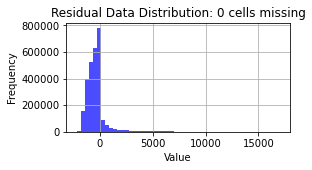

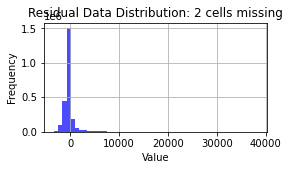

In [37]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

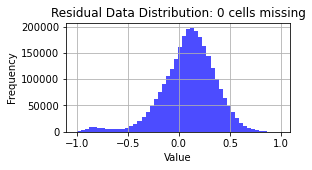

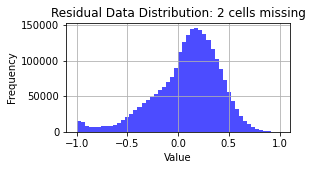

In [38]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

2220.7546890534163


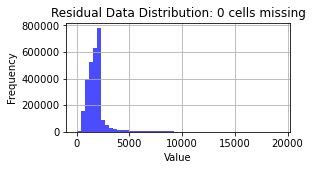

3233.141318141101


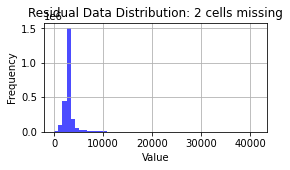

In [39]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

1.0


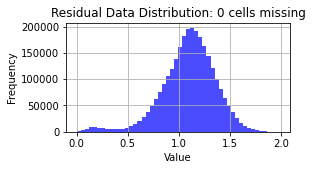

1.0


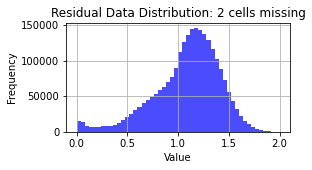

In [40]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Now comparing the Residual Scaled (with pseudobulks and reference MinMax scaled) and the Residual (not scaled, all matrices as used in deconvolution). We can see the impact of scaling in our ability to recover the missing cell type's proportions.

In [41]:
num_missing_cells= [2]
missing_cell_prop[2].columns = ["Fat Cell", "Mesothelial Cell"]

Residual, first not scaling the residual or the NMF factors:

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


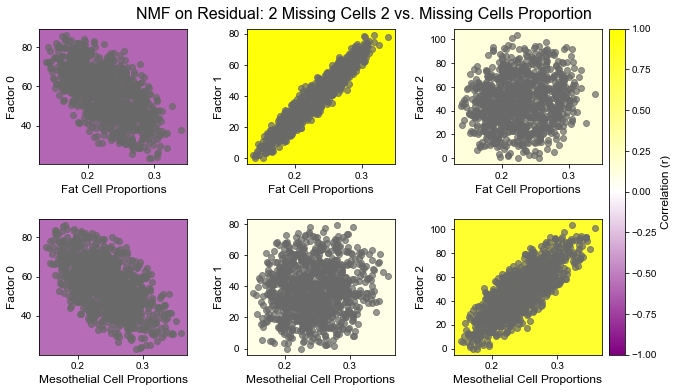

In [42]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = 3
    nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2,  "NMF", rmse_plot)
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

And now scaled:

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


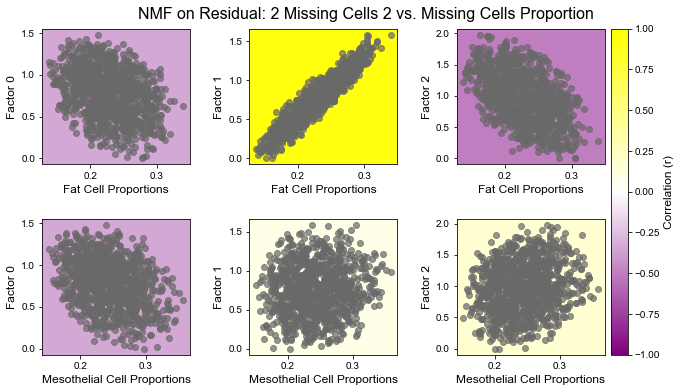

In [43]:
#if proportions are raqndom and RMSE is significant:
if rmse_plot:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df
        #putting each component between 0 and 1 to match proportion range
        pseudo_raw_val = res_nmf_df.values 
        scaler = MinMaxScaler()
        scaler.fit(pseudo_raw_val)
        pseudo_scale = scaler.transform(pseudo_raw_val)
        res_nmf[num] = pd.DataFrame(pseudo_scale)

#if proportions are not raqndom and RMSE is not significant:
else:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter=10000, init = 'nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df

vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, "NMF", rmse_plot)
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 